In [36]:
import sys
sys.path
sys.path.append('../')

In [70]:
%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from naive_autoreg_baselines import fit_and_predict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Params:

In [90]:
aggregate_by_state = False
evaluation_criteria = 'predict current day' #Out of ['hold out counties','predict current day']

## Basic Data Visualization

In [91]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(dir_mod = '../')
df = df.sort_values(load_data.outcome_deaths, ascending=False)
outcome_cases = load_data.outcome_cases # most recent day
outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)

In [92]:
def sum_lists(list_of_lists):
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    return list(sum_arr)
if aggregate_by_state:
    # Aggregate by State
    state_deaths_df = df.groupby('StateNameAbbreviation').deaths.agg(sum_lists).to_frame()
    state_cases_df = df.groupby('StateNameAbbreviation').cases.agg(sum_lists).to_frame()
    df =  pd.concat([state_cases_df,state_deaths_df],axis =1 )

Number of counties with non-zero cases
1333


(array([50., 34., 24., 13., 11., 11.,  8.,  5.,  6., 10.,  4.,  1.,  4.,
         1.,  2.,  2.,  2.,  2.,  3.,  3.,  1.,  1.,  1.,  2.,  0.,  3.,
         2.,  0.,  0.,  0.,  1.,  2.,  0.,  1.,  1.,  0.,  0.,  2.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 21.  ,  29.52,  38.04,  46.56,  55.08,  63.6 ,  72.12,  80.64,
         89.16,  97.68, 106.2 , 114.72, 123.24, 131.76, 140.28, 148.8 ,
        157.32, 165.84, 174.36, 182.88, 191.4 , 199.92, 208.44, 216.96,
        225.48, 234.  , 242.52, 251.04, 259.56, 268.08, 276.6 , 285.12,
        293.64, 302.16, 310.68, 319.2 , 327.72, 336.24, 344.76, 353.28,
        361.8 , 370.32, 378.84, 387.36, 395.88, 404.4 , 412.92, 421.44,
  

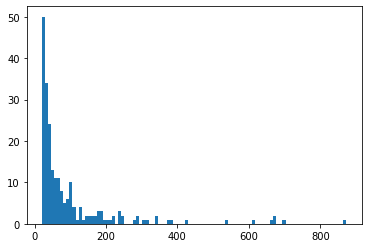

In [93]:
# Distribution of the maximum number of cases
_cases = list(df['cases'])

max_cases = []
for i in range(len(df)):
    max_cases.append(max(_cases[i]))

print('Number of counties with non-zero cases')
print(sum([v >0 for v in max_cases]))


# cases truncated below 20 and above 1000 for plot readability
plt.hist([v for v in max_cases if v > 20 and v < 1000],bins = 100)


In [94]:
sum(max_cases)

53308

In [95]:
print(sum([v > 50 for v in max_cases]))


115


In [96]:
np.quantile(max_cases,1)

15597

Number of counties with non-zero deaths
212


(array([73.,  4.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  2.        ,   8.33333333,  14.66666667,  21.        ,
         27.33333333,  33.66666667,  40.        ,  46.33333333,
         52.66666667,  59.        ,  65.33333333,  71.66666667,
         78.        ,  84.33333333,  90.66666667,  97.        ,
        103.33333333, 109.66666667, 116.        , 122.33333333,
        128.66666667, 135.        , 141.33333333, 147.66666667,
        154.        , 160.33333333, 166.66666667, 173.        ,
        179.33333333, 185.66666667, 192.        ]),
 <a list of 30 Patch objects>)

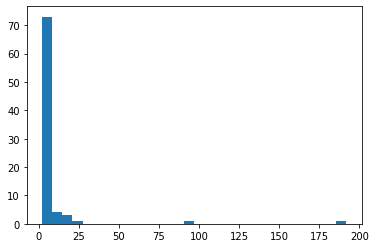

In [97]:
# Distribution of the maximum number of cases
_deaths = list(df['deaths'])

max_deaths = []
for i in range(len(df)):
    max_deaths.append(max(_deaths[i]))

print('Number of counties with non-zero deaths')
print(sum([v >0 for v in max_deaths]))
# plt.hist(max_cases)

# print(sum([v >0 for v in max_cases]))
plt.hist([v for v in max_deaths if v > 1],bins=30)

In [98]:
sum(max_deaths)

764

In [99]:
max(max_deaths)

192

In [100]:
np.quantile(max_deaths,.9999)

178.81900000001087

### Clean data

In [105]:
# Remove counties with zero cases
max_cases = [max(v) for v in df['cases']]
df['max_cases'] = max_cases
# df_with_cases = df[df['max_cases'] > 0]
df =  df[df['max_cases'] > 0]


In [103]:
if evaluation_criteria == 'hold out counties':
    # Randomly select counties for train/test split

    # Shuffle data
    shuffled_df = df_with_cases.sample(frac=1)
    # Break into train test (random k-fold cross val on the training set is done to pick hyperparams)
    train_ratio, val_ratio, test_ratio = .75,0,.25

    train_df = shuffled_df[0:int(train_ratio*len(shuffled_df))]
    test_df = shuffled_df[int(train_ratio*len(shuffled_df))+int(val_ratio*len(shuffled_df)):]
elif evaluation_criteria == 'predict current day':
    # Train df is all previous days
    # Test df is all days including current day
    previous_deaths = [d[:-1] for d in copy.deepcopy(df['deaths'])]
    previous_cases = [c[:-1] for c in copy.deepcopy(df['cases'])]
    train_df = copy.deepcopy(df)
    train_df['deaths'] = previous_deaths
    train_df['cases'] = previous_cases
    test_df = df
else:
    print('Unknown evaluation criteria')
    raise ValueError



## Predict data from model:

In [104]:
predicted_df = fit_and_predict(train_df,test_df)

## Evaluate and visualize model 

In [106]:
def plot_prediction(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    key = 'deaths'
    
    model_predictions = [float(v) for v in row['predicted_deaths']]
    for i,val in enumerate(row[key]):
        if val > 0:
            start_point = i
            break
        
    plt.plot(row[key][start_point:], label=key)
    
    
    plt.plot(model_predictions[start_point:],label='predictions')
    print(model_predictions[start_point:])
    plt.fill_between(list(range(len(row[key][start_point:]))),row[key][start_point:],model_predictions[start_point:])
    plt.legend()
    plt.show()
    

[1.75, 1.75, 2.3125, 7.5625, 12.6875, 13.9375, 22.625, 27.3125, 49.25, 54.3125, 54.3125]


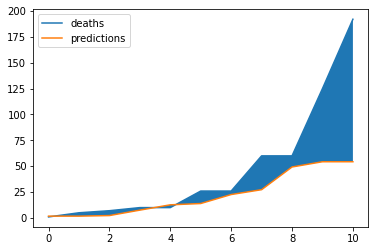

[1.75, 1.75, 1.1875, 2.9375, 7.5, 10.8125, 13.9375, 18.0625, 19.625, 22.6875, 25.625, 29.0625, 37.8125, 42.75, 42.75, 45.875, 49.25, 52.625, 54.3125, 54.3125, 54.3125, 54.3125, 54.3125, 54.3125, 54.3125]


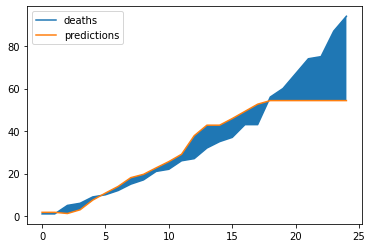

In [108]:
for i in range(len(test_df)):
    row = test_df.iloc[i]
    # If number of deaths greater than 3
    if max(row['deaths']) > 3:
        plot_prediction(row)